In [1]:
# Constrained water and energy balance estimation 
# v4.2: adapted from v4.1 by treating SCF known, G estimated offline
# v4.3: adapted from v4.2 & 3.3 to handle to batch processing on OSC
# v4.4: adapted from v4.3 to update ipopt deprecation
# v4.5: moving σWRFG based on SCF 7/2/20 JLD
# v4.6: adding SDC to objective function: MD & JD: 9/28/20
# v4.7: adding "pseudo-valid prior" to starting points. remove SDC. MD: 1/7/21
# v4.8: tweak error parameters. MD & JD: 1/8/21
# v4.9 prior valid added to objective function. daily G capped in constraints. more outputs written 10/5/21
# v4.9.1 remove SWE from objective
# v4.9.2 added air temp
# v51 Converted to function but still uses textfile as input
# v52 Prototyping to pass the array directly to function [and fixed tab to 4 spaces]
# v53 To set tab to 4 spaces (by copying/pasting)
# v54 combine 9 separate textfile output in one txt file (due to file count limitation on Discover)
# v55 Fixing error due to missing days of data due to Polar nights
# v58 New updates by jack (Nov 2023)
# Jan 29, 2024: Due to error on obj function σWRFG becoming zero, fixed the minimum σWRFG to 25 
# Jun 21, 2024: No change for 1km run here. MODIS with UINT8 did not work likely because of missing due to no-data background and polar nights.

using Random
using JuMP
using Ipopt
using DelimitedFiles
using Statistics
# 0. read in data 

#DataDir = "/Users/jldechow/Documents/GitHub/verse/Testing/DanaPix/inputsScaledSnotel";
#exp_dir = "/Users/jldechow/Documents/GitHub/verse/Testing/DanaPix/inputsScaledSnotel";
DataDir = "/Users/jldechow/Documents/GitHub/verse/Testing/DanaPix/Test"
exp_dir = "/Users/jldechow/Documents/GitHub/verse/Testing/DanaPix/Test";
#DataDir = "/Users/jldechow/Documents/GitHub/verse/Testing/BCK_Pix";
#exp_dir = "/Users/jldechow/Documents/GitHub/verse/Testing/BCK_Pix";


#WRFSWE=readdlm(DataDir * "/WRFSWE.txt"); #[m]
WRFSWE = readdlm("/Users/jldechow/Documents/Projects/UNC/CoReSSD/newSWE.txt"); #[mm]
#WRFP=readdlm(DataDir * "/WRFP.txt"); #[m]
WRFP = readdlm("/Users/jldechow/Documents/Projects/UNC/CoReSSD/newPrecip.txt"); #[mm]
#WRFG=readdlm(DataDir * "/WRFG.txt");
#MSCF=readdlm(DataDir * "/SCF2.txt");
#AirT=readdlm(DataDir * "/AirT.txt");
WRFG=readdlm("/Users/jldechow/Documents/Projects/UNC/CoReSSD/newG.txt"); #[mm]
MSCF=readdlm("/Users/jldechow/Documents/Projects/UNC/CoReSSD/newSCF.txt"); #[mm]
AirT=readdlm("/Users/jldechow/Documents/Projects/UNC/CoReSSD/newAirT.txt"); #[mm]
AirT=(AirT./100).-273.15;
WRFP = WRFP./1000;
WRFSWE  = WRFSWE./1000;

#WRFSWE = WRFSWE.*1.8;
#WRFP = WRFP.*1.8

lookIdx = 0;
nt = 365;

log_filePS = "/Users/jldechow/Documents/GitHub/verse/Testing/DanaPix/Logs/Pix_DanaPS2.txt"  # original

"/Users/jldechow/Documents/GitHub/verse/Testing/DanaPix/Logs/Pix_DanaPS2.txt"

In [2]:
function detPrecipScalar(SCF, mu, sigma, gamma,yMin,yMax,logfile)
    """
    Calculate precip scaling values based on logistic function (tanh)
    Logistic funciton f(x) has output (y) values between [yMin yMax]
    Center of function i.e. inflection point at basinMu
    Parameters:
    ============
    SCFinst: Pixel SCF timeseries -> used to calculate annual average SCF (avgSCF)
    mu: Mean of avgSCF for all pix in basin; Also the inflection point i.e. center point of tanh();
        MUST BE NONNEGATIVE
    sigma : Standard deviation of avgSCF for all pix in basin
    gamma: Steepness parameter for logistic function, calculated separate in detGamma function
    yMin: Minimum output value of logistic function;
        MUST BE NONNEGATIVE
    yMax: Maximum output value of logistic function; 
        MUST BE GREATER THAN yMIN
    =============
    """
   
    # Throw errors for bad inputs
    if yMin < 0 || mu < 0
        throw(DomainError((x, y), "Error! Inputs yMin and basinMu must be non-negative!"))
    end

    if yMin > yMax
        throw(DomainError((x, y), "Error! Input yMax must be greater than yMin!"))
    end
    
    avgSCF = mean(SCF) # Average of SCFinst over entire water year for current pixel
    # Logistic function
    y_norm = 0.5 * (tanh(gamma * (avgSCF - mu)) + 1);
    y = y_norm * (yMax - yMin) + yMin;

        msg = " Precipitation Scalar Record; PSval = $y\n"
        write(logfile, msg)
    return y
end

detPrecipScalar (generic function with 1 method)

In [3]:
# # 1. define parameters
# # 1.1 experiment parameters
# exp_dir = DataDir 

    σWSWE=0.4 # m
    RelPUnc=0.5 #[-]
    σWRFG=100 # W m^-2
    σWMPmin= 1 #.001 #minimum uncertainty in fluxes: 1 mm/day
    badG = 500
    σSCF=.1 # combined uncertainty in observed SCF and SDC
    nt = length(WRFSWE)  # 366  #365  # TODO this need to be updated based on lenght of input vector rather than fixed 365 days
    t=1:nt
    SWEmin=1.0e-6 #1/1000 mm
    ρnew=100 #density of new snow
    Δt=86400 #daily
    Gmax=350 # to prevent craziness. more than adequate for daily
    Gmin=-300 # to prevent craziness. more than adequate for daily
    ρnew=100 #density of new snow
    z0=0.01 # roughness length used in SDC
    mf=1.0 # melt factor used in SDC
    ρWRF=350 #note: previous versions used time-varying snow density but that is not currently exported
    
    tlmSigma = 0.1199
    tlmMu =0.5216
    tlmGamma = 3.0755
    yMin = 0; 
    yMax = 2
# 1.2 physical parameters
    ρw=1000 #density of water
    Lf=0.334E6 #Latent heat of fusion J/kg
    cs_ice=2102 #specific heat capacity for ice J/kg/K

2102

In [4]:
# 1.3.0 Find offset in timing for WRF peak SWE vs MSCF off date

maxWRF = argmax(WRFSWE) ; noSnowSCF = 0 ; noSnowWRF = 0 ; 
for i = 150:nt
    if MSCF[i] == 0
        noSnowSCF = i
        break
    end
end

for i = 150:nt
    if WRFSWE[i] == 0
        noSnowWRF = i
        break
    end
end

offsetIdx = noSnowWRF - maxWRF[1];

#if abs(noSnowSCF-noSnowWRF)<5
#    offsetIdx = 0
#else
#    offsetIdx = wrfOffset
#end

predMaxSWE = noSnowSCF - offsetIdx

228

In [5]:
# 1.3 Fill in missing SCF [Feb 23, 2023]
    MissingSCFData=zeros(nt,1)
    for i=1:nt
        if ismissing(MSCF[i])
            MissingSCFData[i]=1
            MSCF[i]=1  # June 20, 2024: cannot convert a value to missing for assignment. When using uint8 based data.
        end
    end

    # New Updates from Jack (Nov, 2023)
    σWRFG = zeros(nt,1) .+ 25  # maybe 15 is not being used, but we still need to initialze the array
    σWRFG_rel = 0.5
    for i=1:nt
        if MissingSCFData[i]==1 # missing data check
	        σWRFG[i] = badG
        elseif MSCF[i]>=0.1 && WRFSWE[i]>=0.1  # if both are snow covered
            σWRFG[i] = abs(WRFG[i]) * σWRFG_rel  # when WRFG == zero, σWRFG also becomes zero which creates problem of objective function
            # Jan 29, 2024 To solve this problem in obj function: Expression contains an invalid NaN constant. This could be produced by `Inf - Inf`.
            if σWRFG[i] < 25  # or == 0 because this is what was actually causing problem.  
                σWRFG[i] = 25  # σWRFG_rel  #abs(WRFG[i] + eps(Float32)) * σWRFG_rel
            end
        elseif MSCF[i]<0.1 && WRFSWE[i]<0.1 # if both not snowy
            σWRFG[i] = 25
        else
            σWRFG[i] = 500 #if they disagree, then don’t use prior in cost function
        end
    end
 # 1.4 Match up SWE and MSCF
    #for i=1:nt
    #    if MSCF[i]==0  # Nov 04, 2022: "ERROR: LoadError: TypeError: non-boolean (Missing) used in boolean context" because some days there was no MODIS data
   #         WRFSWE[i] = 0
     #   end
   # end

    for i = 100:nt
        if WRFSWE[i] == 0
            lookIdx = i;
            break
        end
    end
   

In [6]:
# 2. compute useful variables and set up  arrays
    # 2.1 define SWEmax: upper limit of SWE, based on observed SCF
    SWEmax=zeros(nt,1)
    for i=1:nt
        if MSCF[i]==0  # TypeError: non-boolean (Missing) used in boolean context
            SWEmax[i]=SWEmin
        else
            SWEmax[i]=5.0
        end
    end

In [7]:
# 2.2 SDC denominator: dependent only on snow density
    DenomSDC=2.5.*z0.*(ρWRF./ρnew).^mf
    
# 2.3 Uncertainty for accumulation 
    σWRFP=zeros(nt,1) 
    for i=1:nt
        if WRFP[i]==0.
            σWRFP[i]=σWMPmin;
        else
            σWRFP[i]=WRFP[i]*RelPUnc;
        end
    end
    # Jan 30, 2023: Modify σWRFP based on number snowy days  
    nsnowday = 0  # number of snow days
    for i=1:nt
        if WRFP[i]>0.001 && AirT[i] < 1.5
            # there is precipitation and temperature is likely to convert it to snow.
            nsnowday += 1
        end
    end
    if nsnowday > 0
        # to prevent σWRFP from becoming zero if nsnowday=0.
        σWRFP = σWRFP .* sqrt(nsnowday * 0.5);
    end

365×1 Matrix{Float64}:
 0.004335323185239094
 0.02167661592619551
 7.0
 7.0
 7.0
 0.017341292740956415
 7.0
 7.0
 7.0
 7.0
 7.0
 7.0
 7.0
 ⋮
 7.0
 7.0
 7.0
 7.0
 7.0
 0.008670646370478189
 7.0
 7.0
 7.0
 7.0
 7.0
 7.0

In [8]:
# Test Precip Scaling
#precipScalar = detPrecipScalar(MSCF, tlmMu, tlmSigma, tlmGamma,yMin,yMax,log_filePS);
#WRFP = precipScalar.*WRFP;
#WRFSWE = precipScalar.*WRFSWE;

In [9]:
# 3. Solve
    # 3.1 Solve for G    
    Gmelt_pv=zeros(nt,1)
    G_pv=zeros(nt,1)
    U_pv=zeros(nt,1)
    SWEpv=WRFSWE
    for i=2:nt
        Gmelt_pv[i-1]=-(SWEpv[i]-SWEpv[i-1]-WRFP[i-1])*Lf*ρw/Δt
        if Gmelt_pv[i-1]<0.
            Gmelt_pv[i-1]=0
            SWEpv[i]=SWEpv[i-1]+WRFP[i-1]
        end
    end
    for i=2:nt
        if Gmelt_pv[i]>0. && MSCF[i] >0.  # TypeError: non-boolean (Missing) used in boolean context
            G_pv[i]=Gmelt_pv[i]#/MSCF[i]
            U_pv[i]=0.
        else
            G_pv[i]=WRFG[i]
            #U_pv[i]=U_pv[i-1]+WRFP[i-1]*AirT[i-1]*ρw*cs_ice + G_pv[i-1]*MSCF[i-1]*Δt  # MethodError: Cannot `convert` an object of type Missing to an object of type Float64
            U_pv[i]=U_pv[i-1]+WRFP[i-1]*AirT[i-1]*ρw*cs_ice + G_pv[i-1]*Δt
            if U_pv[i]>0. || SWEpv[i]==0.
                U_pv[i]=0.
            end
        end
    end

    for i=2:nt
        if Gmelt_pv[i] > Gmax
            σWRFG[i]= 500
            Gmelt_pv[i] = Gmax
        end
    end

In [10]:
# 3.2 Solve for the posterior using prior valid
    m = Model(optimizer_with_attributes(Ipopt.Optimizer, "max_iter"=>5000))
    set_silent(m)
    @variable(m, SWEmin <= SWE[i=1:nt] <= SWEmax[i],start=SWEpv[i] )
    @variable(m,  Precip[i=1:nt]>=0. ,start=WRFP[i])
    @variable(m,  G[i=1:nt] , start=G_pv[i])
    @variable(m, 0 <= Gmelt[i=1:nt] <= Gmax, start=Gmelt_pv[i])
    #@variable(m, 0 <= Gmelt[i=1:nt], start=Gmelt_pv[i])
    @variable(m, Us[i=1:nt] <=0, start=U_pv[i])
    @objective(m,Min,sum((Precip-WRFP).^2 ./σWRFP.^2)  + sum((Gmelt-Gmelt_pv).^2 ./σWRFG.^2) )
    #@objective(m,Min,sum((Precip-WRFP).^2 ./σWRFP.^2)+ sum((G-G_pv).^2 ./σWRFG.^2) )
    for i in 1:nt-1
        @constraint(m,SWE[i+1]==SWE[i]+Precip[i]-Gmelt[i]*Δt/Lf/ρw)
        #@NLconstraint(m,Us[i+1]==Us[i]+(1-(tanh(Us[i]/10000)+1))*G[i]*MSCF[i]*Δt+
        #                       Precip[i]*AirT[i]*ρw*cs_ice) #m x K x kg/m3 x J/kg/K
        #@constraint(m,SWE[i+1]==SWE[i]+Precip[i]-(tanh(Us[i]/10000)+1)*G[i]*Δt/Lf/ρw)
        @NLconstraint(m,Us[i+1]==Us[i]+(1-(tanh(Us[i]/10000)+1))*G[i]*Δt+
                                Precip[i]*AirT[i]*ρw*cs_ice) #m x K x kg/m3 x J/kg/K
    end
    @constraint(m,Us[1]==0) 
    @constraint(m,Us[nt]==0)
    for i in 1:nt
        if MSCF[i]<=0.05
            @constraint(m,SWE[i]==0)
        #else
            #@constraint(m,SWE[i]>=0.001)
        end
    end
    
    for i in 1:nt
        #@NLconstraint(m,Gmelt[i]==G[i]*MSCF[i]*(tanh(Us[i]/10000)+1))
        @NLconstraint(m,Gmelt[i]==G[i]*(tanh(Us[i]/10000)+1))
    end

    #@constraint(m,sum(SWE[1:nt])>=sum(SWEpv[1:nt])-0.2*sum(SWEpv[1:nt]))
optimize!(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [11]:
# 4. output
    SWEhat=JuMP.value.(SWE);
    GmeltHat=JuMP.value.(Gmelt);
    Ghat=JuMP.value.(G);
    Ushat=JuMP.value.(Us);
    Phat=JuMP.value.(Precip);

In [12]:
# 5. Write Files
    writedlm(exp_dir * "/SWE.txt",SWEhat)
    writedlm(exp_dir * "/Gmelt.txt",GmeltHat)
    writedlm(exp_dir * "/G.txt",Ghat)
    writedlm(exp_dir * "/Precip.txt",Phat)
    writedlm(exp_dir * "/Us.txt",Ushat)
    writedlm(exp_dir * "/Gpv.txt",G_pv)
    writedlm(exp_dir * "/Gmeltpv.txt",Gmelt_pv)
    writedlm(exp_dir * "/Upv.txt",U_pv)
    writedlm(exp_dir * "/SWEpv.txt",SWEpv)

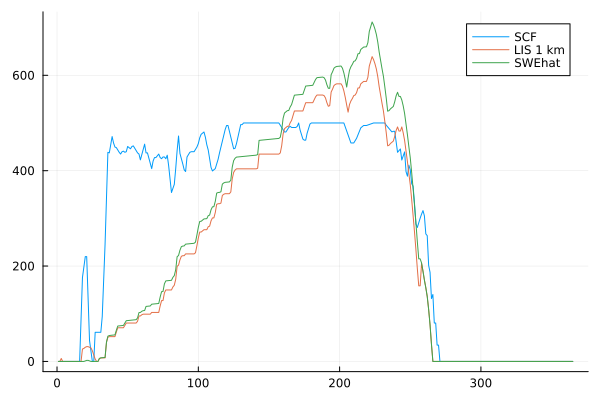

In [39]:
using Plots
# reload WRFSWE to make sure it isn't the changed version
#SNOTEL = readdlm(DataDir * "/Dana16_mm.txt"); #[mm]
#csd = readdlm(DataDir *"/CSD_DANA_SWE.txt"); 
#WRFSWE=readdlm(DataDir * "/WRFSWE.txt"); #[m]
#WRFSWE = WRFSWE.*1.8
#jackSWE = readdlm("/Users/jldechow/Documents/GitHub/verse/Testing/DanaPix/Test/SWE.txt")
sweHatPlot = SWEhat.*1000;
#jackSWEplot = jackSWE.*1000;
mSCFPlot = MSCF.*500;
plot(t,mSCFPlot,label="SCF")
plot!(t,WRFSWE.*1000,label="LIS 1 km")
#plot!(t,SWEpv.*1000,label = "SWEpv")
plot!(t,sweHatPlot,label="SWEhat")
#plot!(t,csd.*1000,label = "CoReSSD 1km ")
#plot!(t,SNOTEL,label = "Snow Pillow")
#plot!(t,jackSWEplot,label = "SCF smoothed estimate")

In [14]:
writedlm("/Users/jldechow/Documents/Projects/UNC/CoReSSD/precipScalarSWE.txt",sweHatPlot)


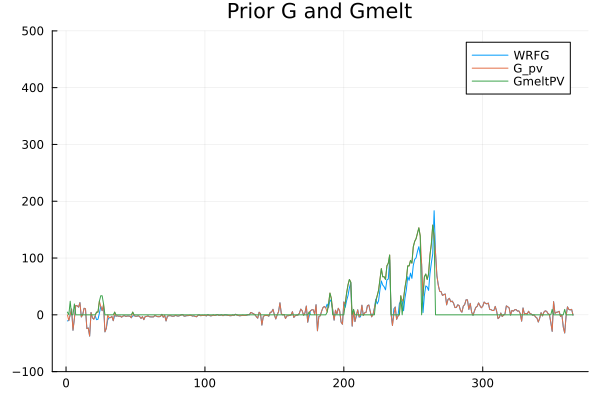

In [15]:
plot(t,WRFG,label="WRFG")
plot!(t,G_pv,label = "G_pv")
plot!(t,Gmelt_pv,label="GmeltPV")
plot!(ylimits=(-100,500))
plot!(title = "Prior G and Gmelt")

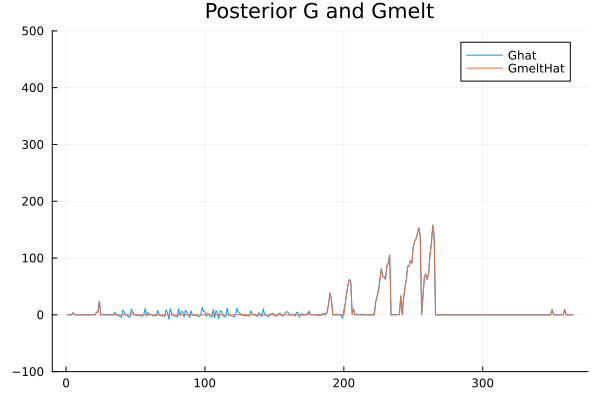

In [16]:
plot(t,Ghat,label="Ghat")
plot!(t,GmeltHat,label="GmeltHat")
plot!(ylimits=(-100,500))
plot!(title = "Posterior G and Gmelt")

In [17]:
holdWRFP = WRFP.*1000
holdPhat = Phat.*1000;
cumuWRFP = cumsum(holdWRFP[:])
cumuPhat = cumsum(holdPhat[:])
writedlm("/Users/jldechow/Documents/Projects/UNC/CoReSSD/precipScalarCumuWRFP.txt",cumuWRFP)
writedlm("/Users/jldechow/Documents/Projects/UNC/CoReSSD/precipScalarCumuPhat.txt",cumuPhat)

writedlm("/Users/jldechow/Documents/Projects/UNC/CoReSSD/precipScalarWRFSWE.txt",SWEpv)

plot(t,cumuWRFP,label = "Input CuPrecip")
plot!(t,cumuPhat,label = "Output CuPrecip")
plot!(t,WRFSWE,label="LIS SWE")
plot!(t,sweHatPlot,label="Blender SWE")
plot!(t,mSCFPlot,label="SCF")
plot!(title = "SWE + Cumulative Precip Comparison")
plot!(t,SNOTEL,label = "SNOTEL SWE")

LoadError: UndefVarError: `SNOTEL` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
findmax(cumuWRFP)[1]

889.3605848576208

In [19]:
cumuP = cumsum(WRFP[:])
findmax(cumuP)[1]

0.8893605848576206

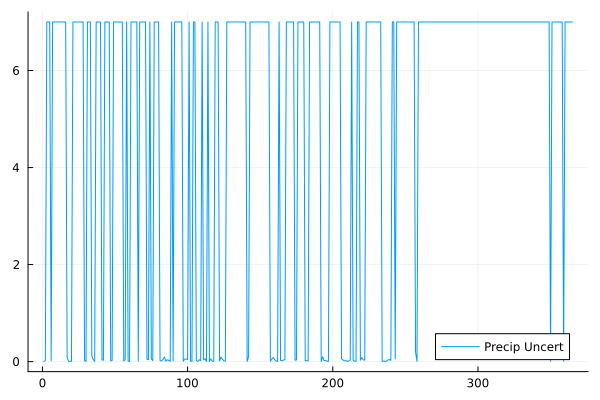

In [20]:
plot(t,σWRFP,label = "Precip Uncert")
#plot!(t,σWRFG,label = "Heat Flux Uncert")


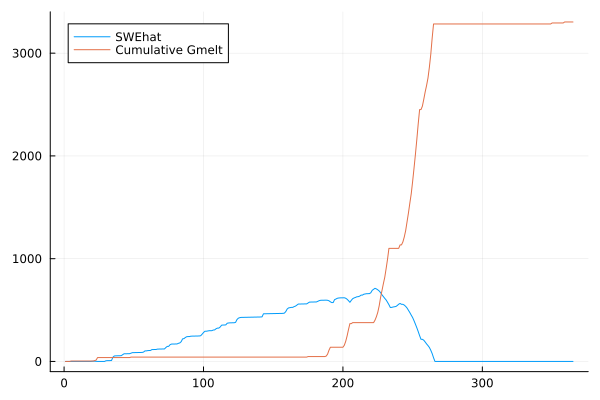

In [21]:
cumuGmelt = cumsum(GmeltHat[1:365])

plot(t,sweHatPlot,label="SWEhat")
plot!(t,cumuGmelt,label = "Cumulative Gmelt")

In [22]:
look = argmax(WRFSWE)
scfOffDate = 0
wrfNoSnowDate = 0
for i = 150:nt
    if MSCF[i] == 0
        scfOffDate = i
        break
    end
end

for i = 150:nt
    if WRFSWE[i] == 0
        wrfNoSnowDate = i
        break
    end
end

In [23]:
findmax(WRFSWE)[1]

0.6391505038809641

In [24]:
findmax(WRFSWE)[1]-(findmax(csd)[1]*1000)

LoadError: UndefVarError: `csd` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [25]:
findmax(WRFSWE)[1]-findmax(sweHatPlot)[1]

-711.1405418232123

In [26]:
scfOffDate

271

In [27]:
wrfNoSnowDate

266

In [28]:
wrfTimingOffset = wrfNoSnowDate - look[1]

43

In [29]:
findmax(sweHatPlot)[1]/findmax(jackSWEplot)[1]

LoadError: UndefVarError: `jackSWEplot` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [30]:
#for i in 1:predMaxSWE-3
#        @NLconstraint(m,SWE[i]<findmax(SWE)[1])
#    end
#    for i in predMaxSWE+3:nt
#        @NLconstraint(m,SWE[i]<findmax(SWE)[1])
#    end 